# photo-z estimation for edfs and cluster lensing
- Xiangchong Li, Tianqing Zhang, Eric Charles, Sam, Schmidt
- LSST Science Piplines version: Weekly 2025_49

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

import fitsio
import xlens

import tables_io
import h5py
from astropy.table import Table
from astropy.stats import biweight_location, biweight_scale
from scipy.stats import sigmaclip

# =============================
# Matplotlib defaults
# =============================
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20
plt.rc("font", size=BIGGER_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)
plt.rc("axes", labelsize=BIGGER_SIZE)
plt.rc("xtick", labelsize=BIGGER_SIZE)
plt.rc("ytick", labelsize=BIGGER_SIZE)
plt.rc("legend", fontsize=BIGGER_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

In [2]:
pscratch= "/gpfs02/astro/workarea/xli6/"
Dir = os.path.join(
    pscratch,
    "work/DP1/"
)
rail_pz_h5 = os.path.join(
    Dir, "photoz",
    "fzb_6bands/projects/com_cam/data/gold_rubin/output_estimate_fzboost.hdf5",
)

MODEL_PATH = os.path.join(
    Dir, "photoz",
    "fzb_6bands/projects/com_cam/data/gold_rubin/model_inform_fzboost.pkl",
)

In [3]:
data_fname = os.path.join(Dir, "rail_data", "data_with_mag.hdf5")
df = tables_io.read(
    data_fname,
    tType="astropyTable",
)
train_fname = os.path.join(Dir, "rail_data", "train_with_mag.hdf5")
df_train = tables_io.read(
    train_fname,
    tType="astropyTable",
)

test_fname = os.path.join(Dir, "rail_data", "test_with_mag.hdf5")
df_test = tables_io.read(
    test_fname,
    tType="pandasDataFrame",
)

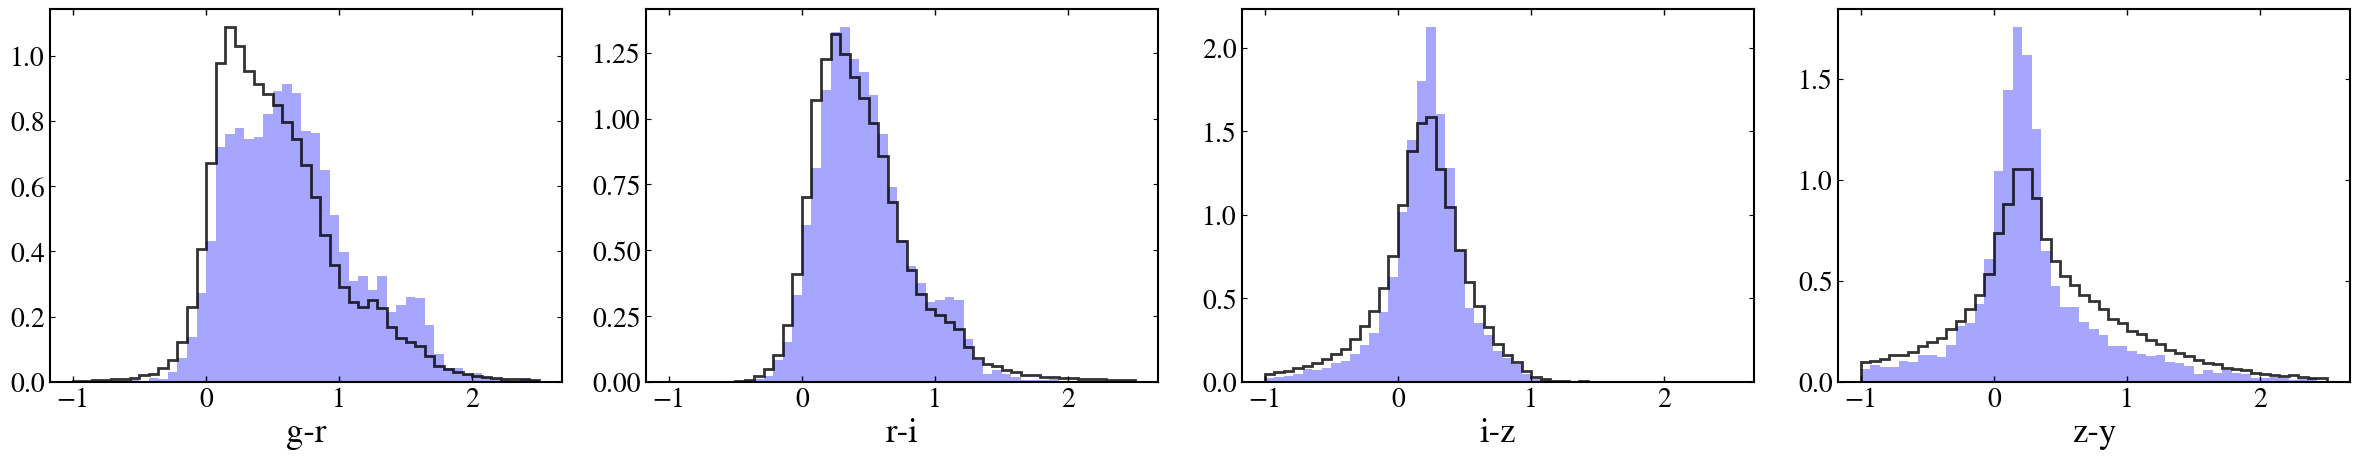

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
xbins = np.linspace(0, 4, 14)
magbins = np.linspace(14, 26.0, 52)
colorbins = np.linspace(-1, 2.5, 50)
bands = "grizy"
for i in range(4):
    bandi = bands[i]
    bandj = bands[i + 1]
    xi = f"{bandi}_mag_gauss2"
    xj = f"{bandj}_mag_gauss2"
    axs[i].hist(df_train[xi] - df_train[xj], bins=colorbins, alpha=0.35, color="b", density=True)
    axs[i].hist(df[xi] - df[xj], bins=colorbins, alpha=0.8, color="k", density=True, histtype="step", linewidth=2.0)
    axs[i].set_xlabel(f"{bandi}-{bandj}", fontsize=25)
plt.tight_layout()

In [5]:
pdfs = tables_io.read(rail_pz_h5)["data"]["yvals"]
ancil = tables_io.read(rail_pz_h5)["ancil"]

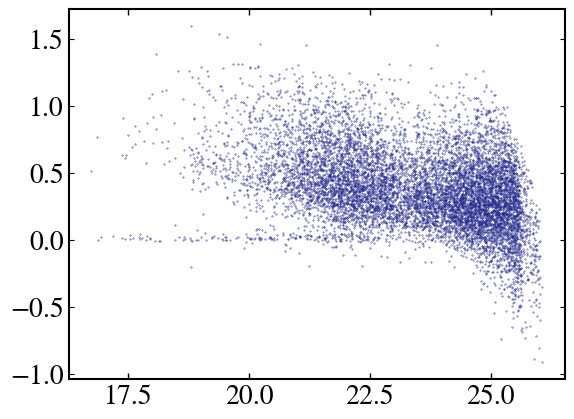

In [6]:
# remove stars in the catalog with resolution cut
plt.scatter(df_train["i_mag_gauss2"], (df_train["i_fpfs1_m00"] + df_train["i_fpfs1_m20"]) / df_train["i_fpfs1_m00"], s=0.1)

Text(0, 0.5, '$z_\\text{est}$')

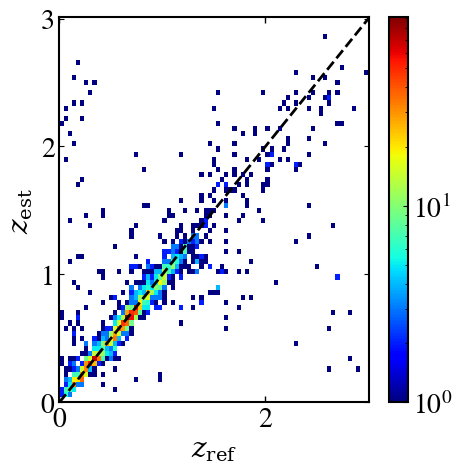

In [7]:
import xlens
out = xlens.catalog.redshift.get_point_estimates_from_pdfs(pdfs)
fzb_mode = np.ravel(ancil["zmode"])
fzb_mode = np.ravel(ancil["z_median"])
fzb_mode = np.ravel(out["z500"])
z_truth = np.ravel(ancil["redshift"])
msk = (
    (df_test["u_mag_gauss2"] < 26.4) & 
    (df_test["g_mag_gauss2"] < 27.8) & 
    (df_test["r_mag_gauss2"] < 27.1) & 
    (df_test["i_mag_gauss2"] < 24.5) & 
    (df_test["z_mag_gauss2"] < 25.8) & 
    (df_test["y_mag_gauss2"] < 24.6) &
    ((df_test["i_fpfs1_m00"] + df_test["i_fpfs1_m20"]) / df_test["i_fpfs1_m00"] > 0.05)
).to_numpy()
fig, axes = plt.subplots(1,1, figsize=(5, 5))
plt.hist2d(z_truth[msk], fzb_mode[msk], range = ((0,4), (0,4)), bins = (100,100),
           cmap = 'jet', norm=colors.LogNorm())
plt.xlim(0,3.01)
plt.ylim(0,3.01)
plt.plot(np.linspace(0, 4.1), np.linspace(0, 4.1), ls="--", color="black")
plt.colorbar()

plt.xlabel(r'$z_\text{ref}$')
plt.ylabel(r'$z_\text{est}$')

In [8]:
def compute_nmad(dz: np.ndarray):
    med_dz = np.median(dz)
    return 1.48 * np.median(np.abs(dz - med_dz))


def get_biweight_mean_sigma_outlier(
    subset: np.ndarray, nclip: int = 0, abs_out_thresh: float = 0.15
):
    if sigmaclip is None or biweight_location is None or biweight_scale is None:
        raise RuntimeError("scipy and astropy.stats are required for this function")
    subset_clip, _, _ = sigmaclip(subset, low=99, high=99)
    for _ in range(nclip):
        subset_clip, _, _ = sigmaclip(subset_clip, low=5, high=5)

    mean = biweight_location(subset_clip)
    std = biweight_scale(subset_clip)
    nmad = compute_nmad(subset_clip)
    outlier_rate = np.sum(np.abs(subset) > np.min([3 * biweight_scale(subset_clip), 0.06])) / len(subset)
    abs_outlier_rate = np.sum(np.abs(subset) > abs_out_thresh) / len(subset)

    return (
        float(mean),
        float(std / np.sqrt(len(subset_clip))),
        float(std),
        float(nmad),
        float(outlier_rate),
        float(abs_outlier_rate),
    )


def process_data(
    zphot: np.ndarray,
    specz: np.ndarray,
    low: float = 0.01,
    high: float = 2.0,
    nclip: int = 0,
    nbin: int = 10,
    zbin_type: str = "spec",
    mag = None,
):
    if sigmaclip is None:
        raise RuntimeError("scipy is required for process_data")

    dz = (zphot - specz) / (1 + specz)
    z_bins = np.linspace(low, high, nbin)

    if zbin_type == "spec":
        zx = specz
    elif zbin_type == "mag":
        zx = mag if mag is not None else specz
    else:
        zx = zphot

    bin_indices = np.digitize(zx, bins=z_bins) - 1

    biweight_mean: list[float] = []
    biweight_std: list[float] = []
    biweight_sigma: list[float] = []
    nmad_list: list[float] = []
    biweight_outlier: list[float] = []
    z_mean: list[float] = []
    qt_95_low: list[float] = []
    qt_68_low: list[float] = []
    median: list[float] = []
    qt_68_high: list[float] = []
    qt_95_high: list[float] = []

    for i in range(len(z_bins) - 1):
        subset = dz[bin_indices == i]
        if len(subset) < 1:
            continue
        subset_clip, _, _ = sigmaclip(subset, low=5, high=5)

        biweight_mean.append(float(np.median(subset_clip)))
        biweight_std.append(float(np.std(subset_clip) / np.sqrt(len(subset_clip))))
        biweight_sigma.append(float(np.std(subset_clip)))
        nmad_list.append(compute_nmad(subset_clip))
        outlier_rate = np.sum(np.abs(subset) > 0.15) / len(subset)
        biweight_outlier.append(float(outlier_rate))

        qt_95_low.append(float(np.percentile(subset, 2.5)))
        qt_68_low.append(float(np.percentile(subset, 16)))
        median.append(float(np.percentile(subset, 50)))
        qt_68_high.append(float(np.percentile(subset, 84)))
        qt_95_high.append(float(np.percentile(subset, 97.5)))

        z_mean.append(float(np.mean(zx[bin_indices == i])))

    return {
        "z_mean": z_mean,
        "biweight_mean": biweight_mean,
        "biweight_std": biweight_std,
        "biweight_sigma": biweight_sigma,
        "biweight_outlier": biweight_outlier,
        "qt_95_low": qt_95_low,
        "qt_68_low": qt_68_low,
        "median": median,
        "qt_68_high": qt_68_high,
        "qt_95_high": qt_95_high,
        "nmad": nmad_list,
    }

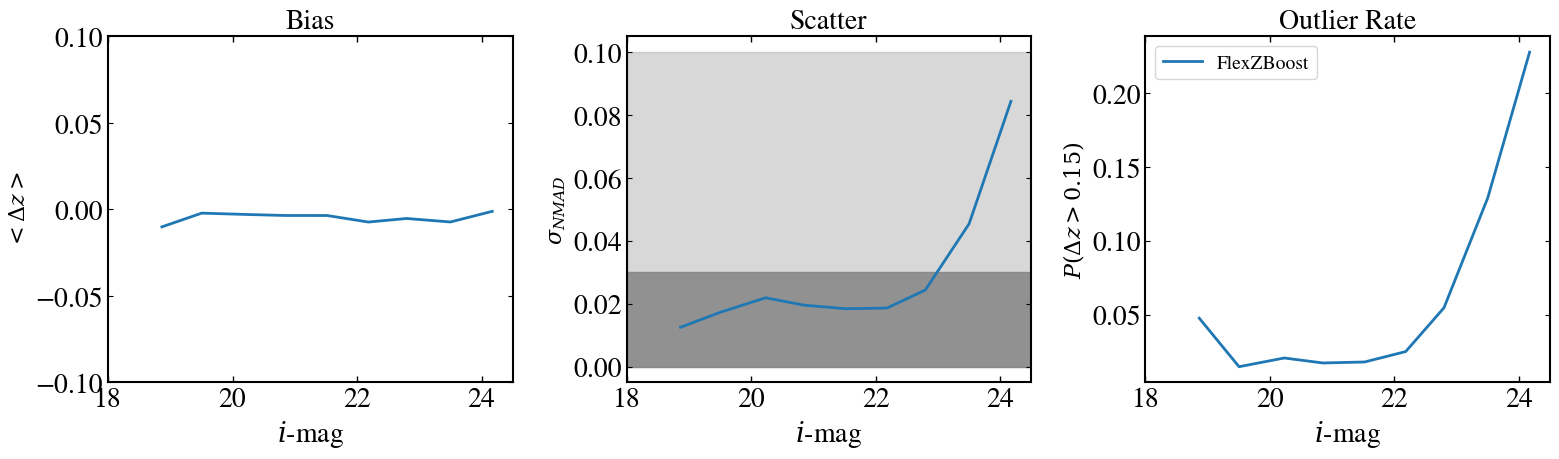

In [9]:
algorithms = ['fzboost']
method_name_list = ['FlexZBoost', 'BPz', 'CMNN' ,'DNF']
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#17becf"
]
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
metric_names = [r'$< \Delta z >$', r'$\sigma_{NMAD}$', r'$P(\Delta z > 0.15)$']
title = ['Bias', 'Scatter', 'Outlier Rate']
y_keys = ['biweight_mean', 'nmad', 'biweight_outlier']
for algo, color, algo_name in zip(algorithms, color_list, method_name_list):
    result = process_data(
        zphot=fzb_mode[msk], 
        specz=z_truth[msk], 
        low=18.5, high=24.5, 
        nbin=10, 
        nclip = 0,  
        zbin_type = "mag", 
        mag = df_test['i_mag_gauss2'][msk]
    )
    for i in range(3):
        axes[i].plot(result['z_mean'], result[y_keys[i]], label=algo_name, color=color)
        axes[i].set_title(title[i])
        axes[i].set_xlabel(r'$i$-mag')

axes[0].set_ylim(-0.1, 0.1)
axes[0].set_xlim(18, 24.5)
axes[0].plot([0,2], [0, 0], '--', color = 'black', alpha = 0.3)
axes[1].axhspan(0.0, 0.03, alpha=0.8, color="gray")
axes[1].axhspan(0.0, 0.10, alpha=0.3, color="gray")

# --- Format plots ---
for i, ax in enumerate(axes):
    ax.set_ylabel(metric_names[i], fontsize=16)
axes[2].legend(loc='upper left', ncol=2, fontsize=14)
plt.tight_layout()

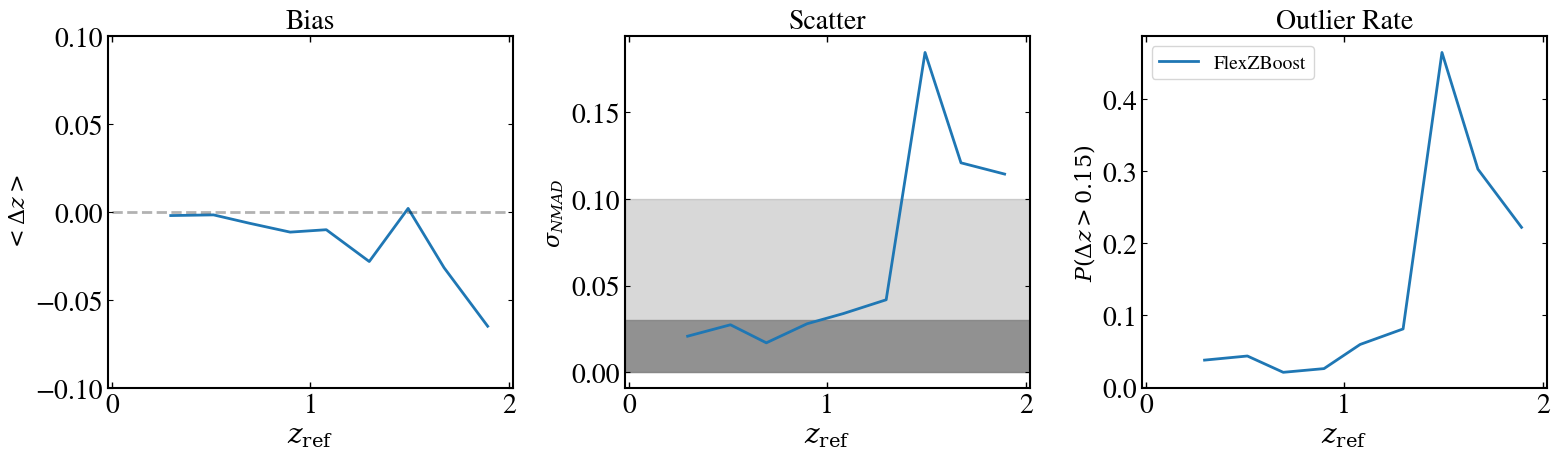

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
metric_names = [r'$< \Delta z >$', r'$\sigma_{NMAD}$', r'$P(\Delta z > 0.15)$']
title = ['Bias', 'Scatter', 'Outlier Rate']
y_keys = ['biweight_mean', 'nmad', 'biweight_outlier']
for algo, color, algo_name in zip(algorithms, color_list, method_name_list):
    result = process_data(
        zphot=fzb_mode[msk], 
        specz=z_truth[msk], 
        low=0.2, high=2.0, 
        nbin=10, 
        nclip=0,  
        zbin_type="spec", 
    )
    for i in range(3):
        axes[i].plot(result['z_mean'], result[y_keys[i]], label=algo_name, color=color)
        axes[i].set_title(title[i])
        axes[i].set_xlabel(r'$z_\text{ref}$')

axes[0].set_ylim(-0.1, 0.1)
axes[0].set_xlim(-0.02, 2.02)
axes[0].plot([0,2], [0, 0], '--', color = 'black', alpha = 0.3)

# --- Format plots ---
for i, ax in enumerate(axes):
    ax.set_ylabel(metric_names[i], fontsize=16)
axes[2].legend(loc='upper left', ncol=2, fontsize=14)
axes[1].axhspan(0.0, 0.03, alpha=0.8, color="gray")
axes[1].axhspan(0.0, 0.10, alpha=0.3, color="gray")
plt.tight_layout()